# Analyzing Contextualized Models

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes

X, Y = load_diabetes(return_X_y=True, as_frame=True)
Y = np.expand_dims(Y.values, axis=-1)
C = X[['age', 'sex', 'bmi']]
X.drop(['age', 'sex', 'bmi'], axis=1, inplace=True)

seed = 1
C_train, C_test, X_train, X_test, Y_train, Y_test = train_test_split(C, X, Y, test_size=0.20, random_state=seed)

# Save/load the trained model.

In [2]:
from contextualized.utils import load

save_path = './easy_demo_model.pt'
model = load(save_path)

# Inspect the model predictions.

We can use standard plotting tools to inspect the model predictions.

In [3]:
%%capture
predicted_probs = model.predict(C.values, X.values)[:, 0]

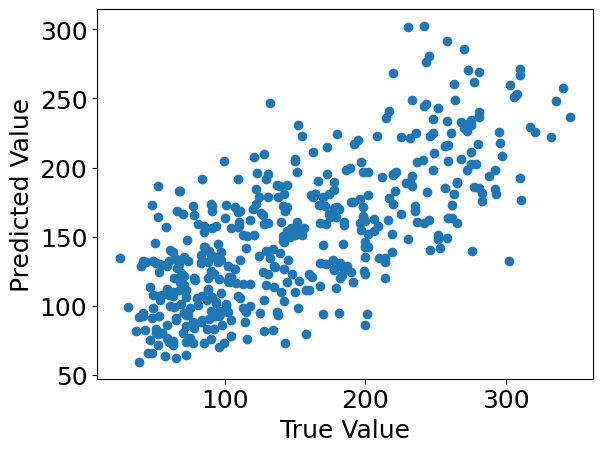

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})

plt.scatter(Y[:, 0], predicted_probs)
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.show()

# Check what the individual bootstrap models learned.

Since we're bootstrapping for robustness, we can also access individual bootstrap runs with the `individual_preds` keyword to get confidence intervals.

In [5]:
%%capture
model_preds = model.predict(C.values, X.values, individual_preds=True)
model_preds.shape  # (n_bootstraps, n_samples, n_outputs)

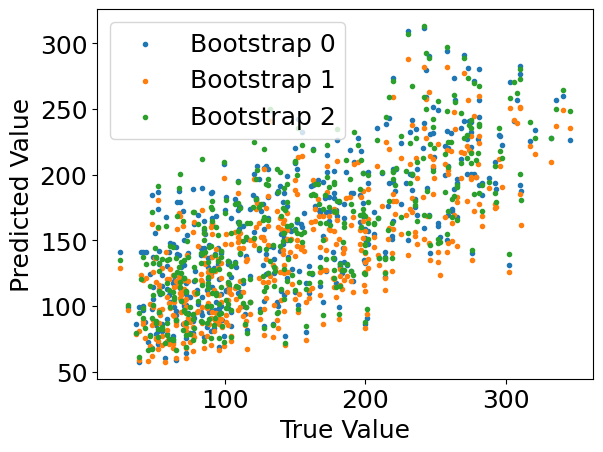

In [6]:
for i, pred in enumerate(model_preds):
    plt.scatter(Y[:, 0],
                pred[:, 0],
                label='Bootstrap {}'.format(i),
                marker='.')
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.show()

# Check what contextualized parameters the models learned.

In [7]:
%%capture
betas, mus = model.predict_params(C.values, individual_preds=False)
betas.shape # (n_samples, n_outputs, n_predictors)
mus.shape  # (n_samples, n_outputs)

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


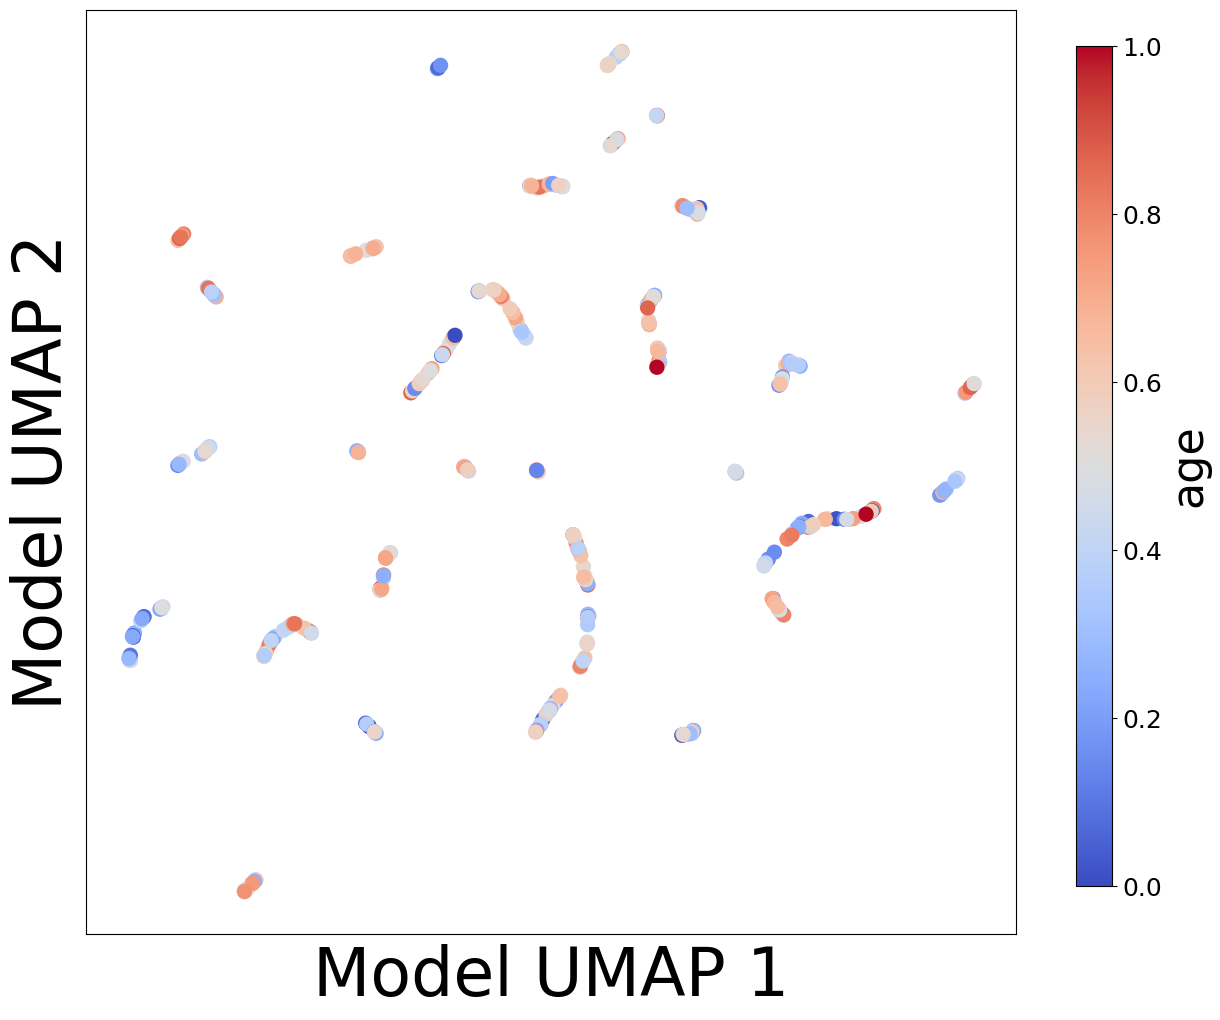

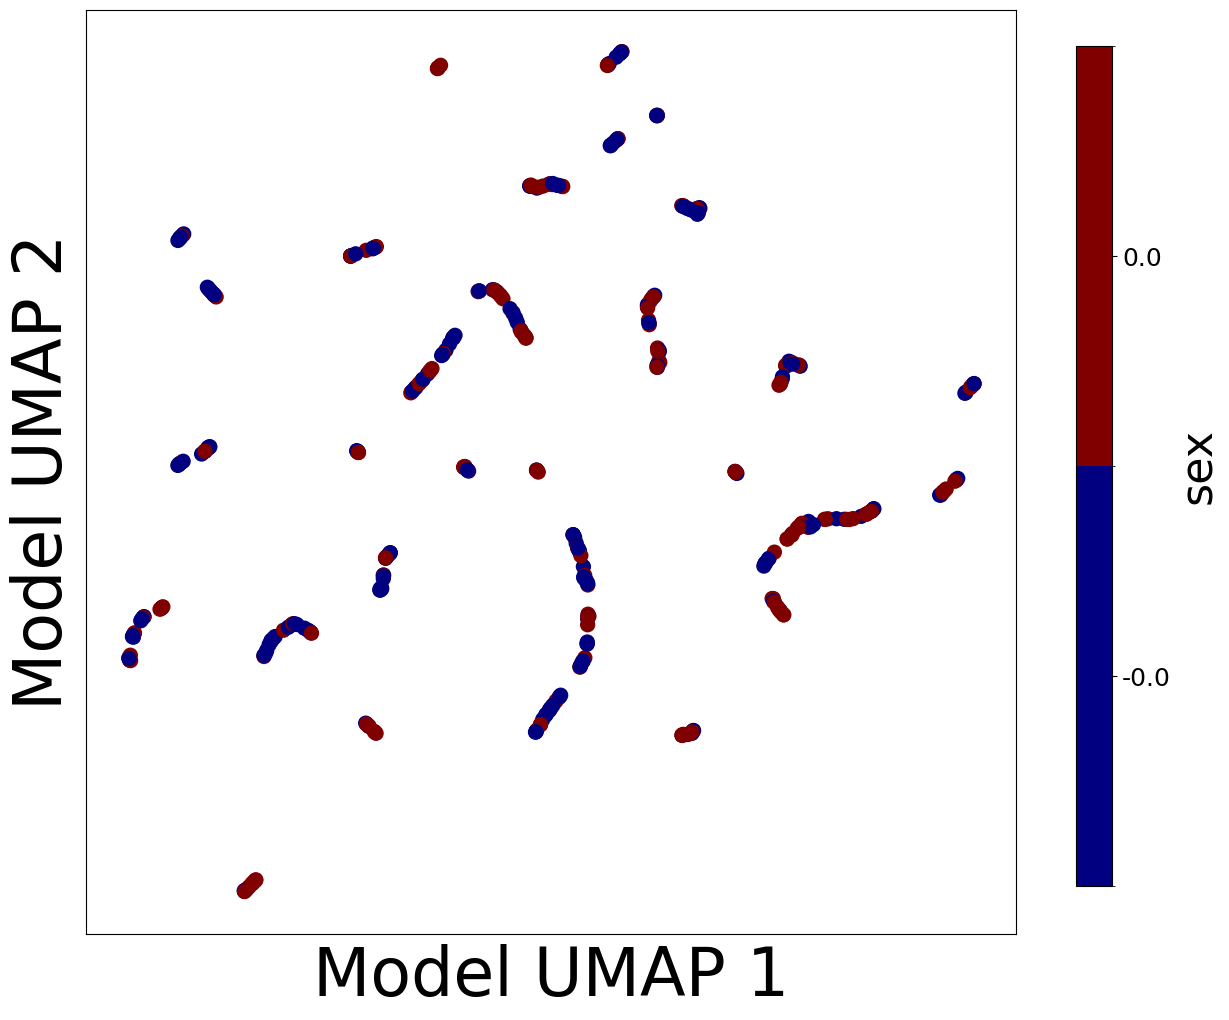

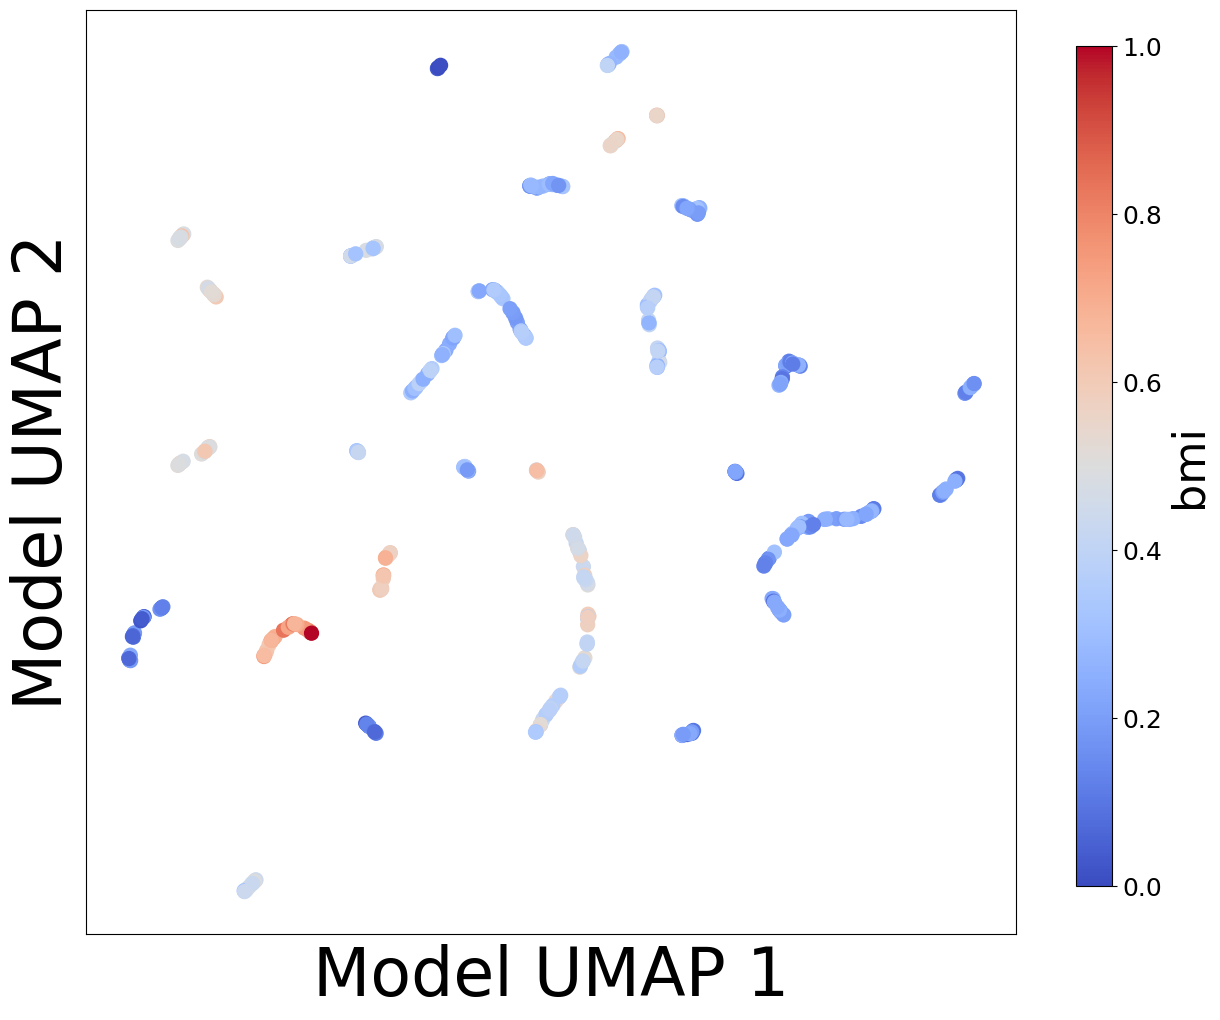

In [8]:
# To get a sense of how the models are clusterd, let's embed the models is a 2-D space and visualize them.

# Betas are shape:
# (n_samples, n_outputs, n_predictors)
# Let's squeeze out the n_outputs axis since we only have 1 output in this example.
betas = np.squeeze(betas)

from umap import UMAP
um = UMAP(n_neighbors=5)
model_reps = um.fit_transform(betas)

from contextualized.analysis.embeddings import plot_embedding_for_all_covars
plot_embedding_for_all_covars(model_reps, C, xlabel='Model UMAP 1', ylabel='Model UMAP 2')

## What are the homogeneous predictors?

In [9]:
from contextualized.analysis.effects import (
    plot_homogeneous_context_effects,
    plot_homogeneous_predictor_effects,
    plot_heterogeneous_predictor_effects,
)

/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

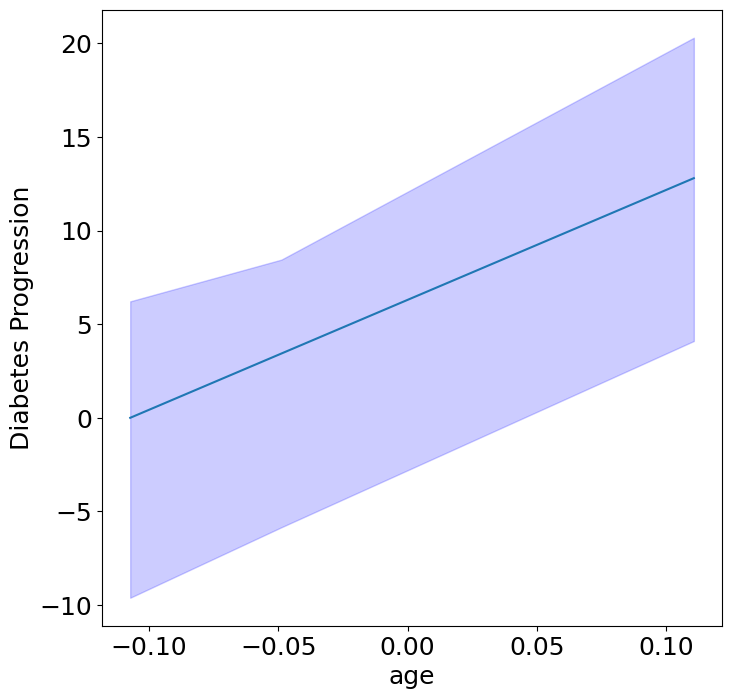

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

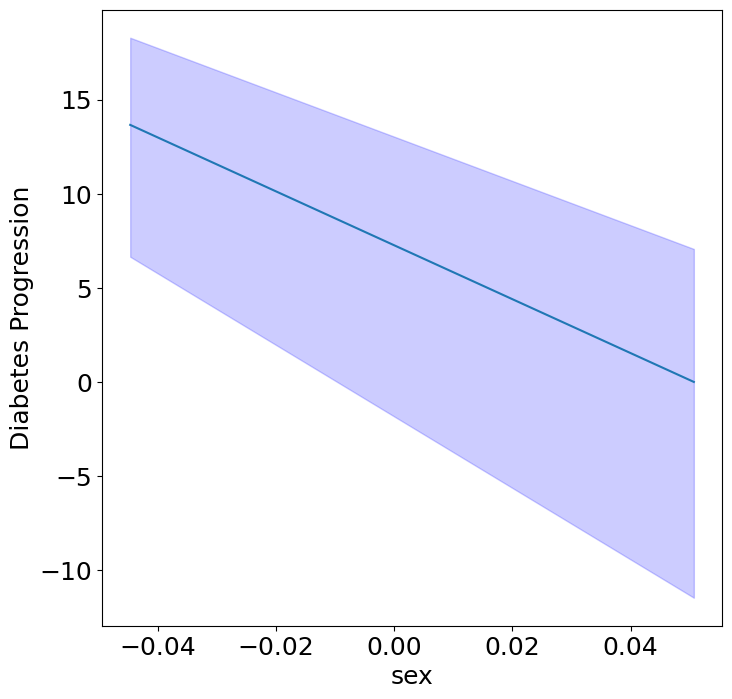

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

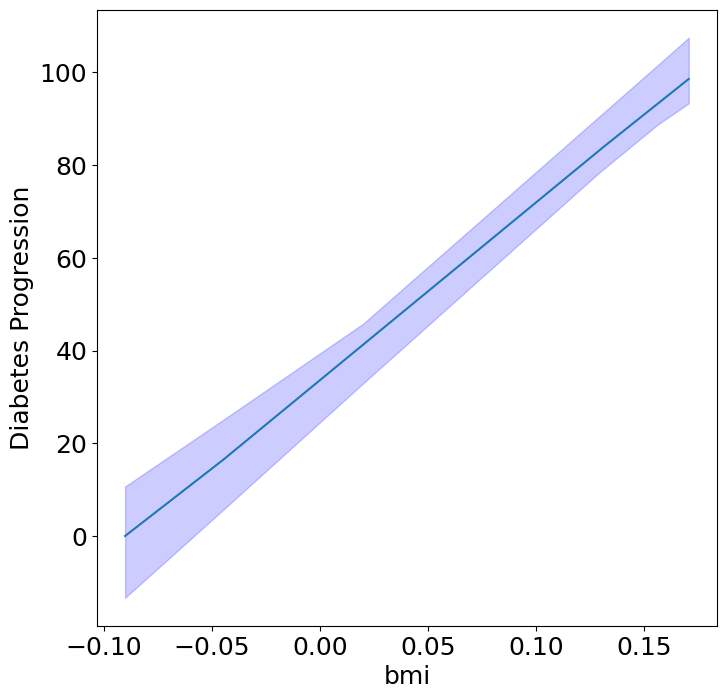

In [10]:
# First, we can see the homogeneous effects of context.
plot_homogeneous_context_effects(
    model, C, classification=False,
    ylabel="Diabetes Progression",
    verbose=False)

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

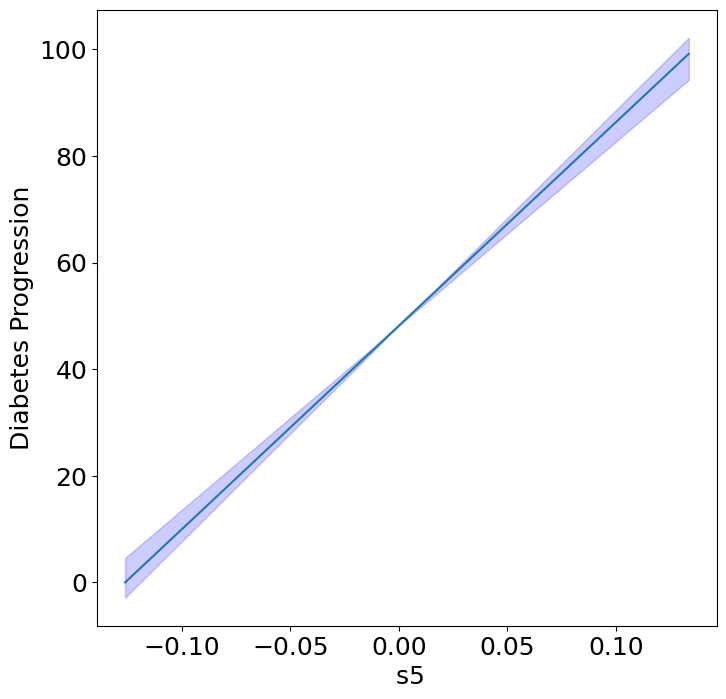

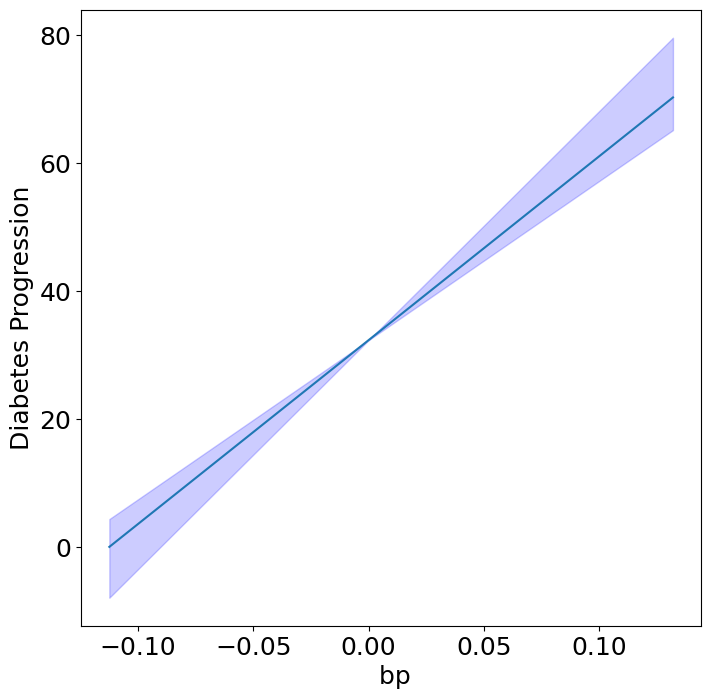

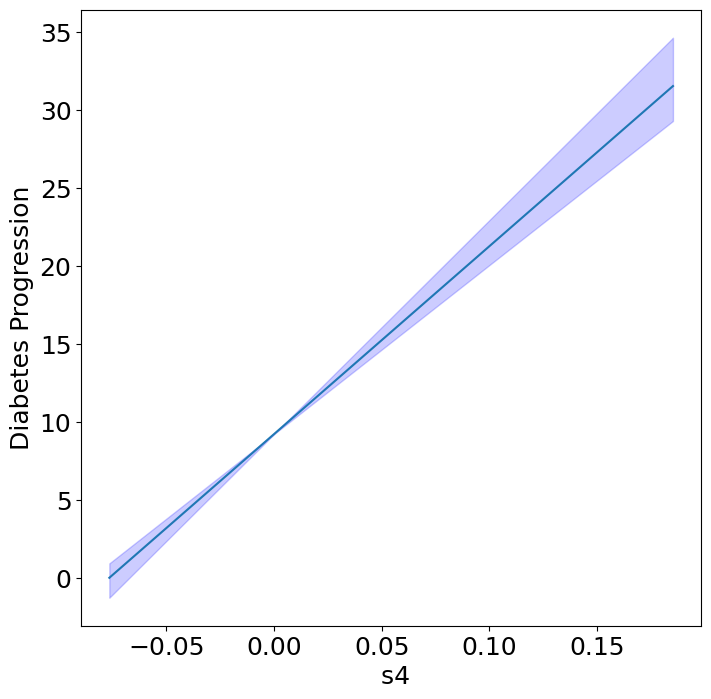

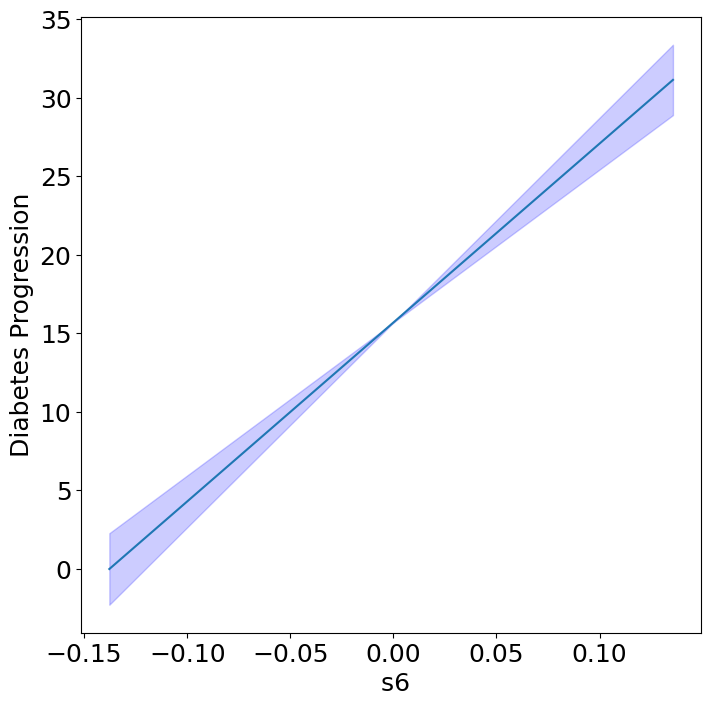

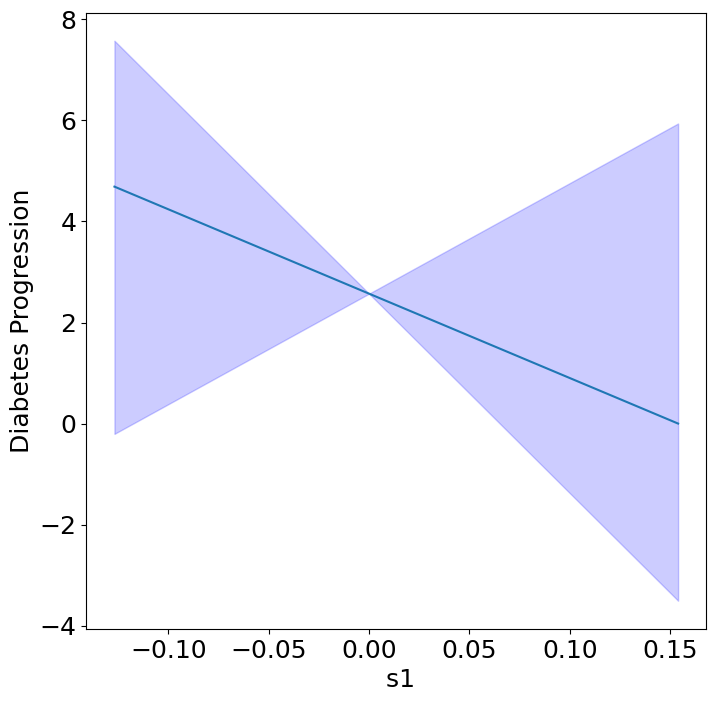

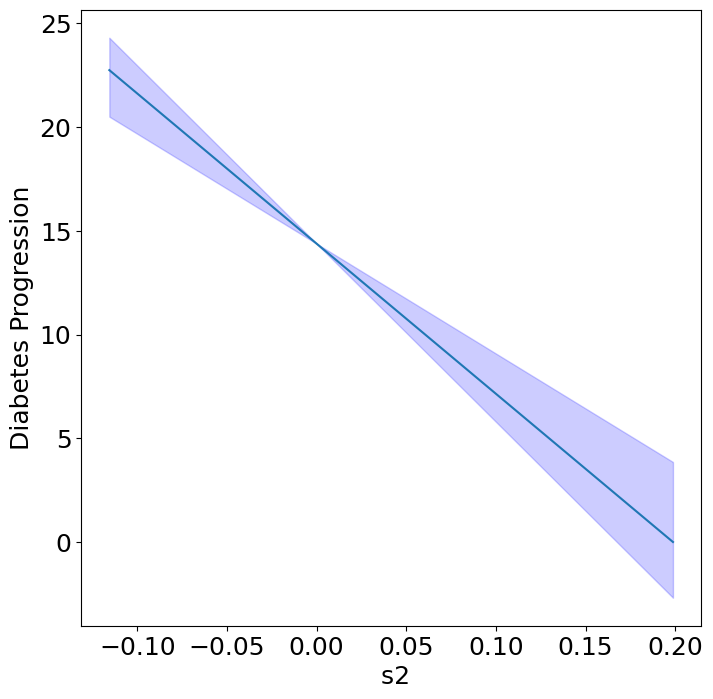

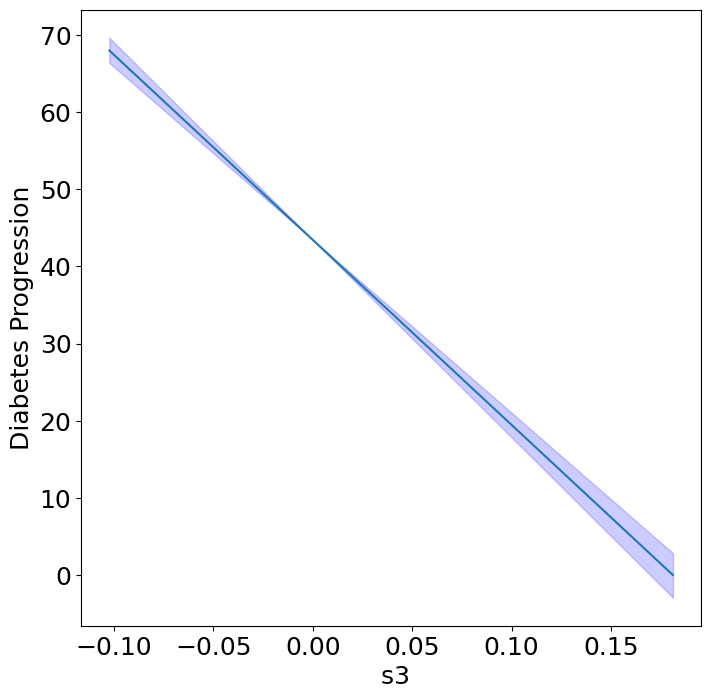

In [11]:
# Second, we can see the homogeneous effects of the predictors.
plot_homogeneous_predictor_effects(
    model, C, X,
    ylabel="Diabetes Progression",
    classification=False)

## What are the heterogeneous effects (effects of predictors than change based on context)?

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

Predicting: 282it [00:00, ?it/s]

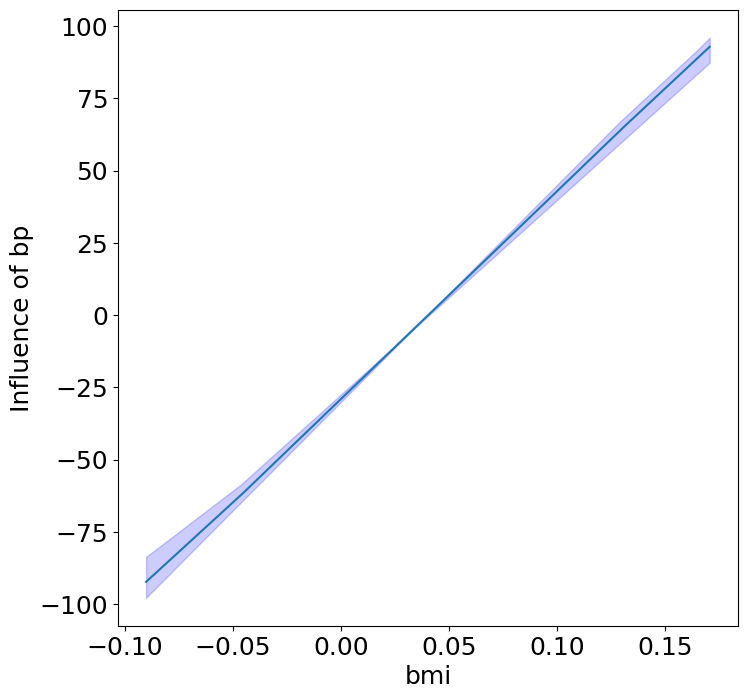

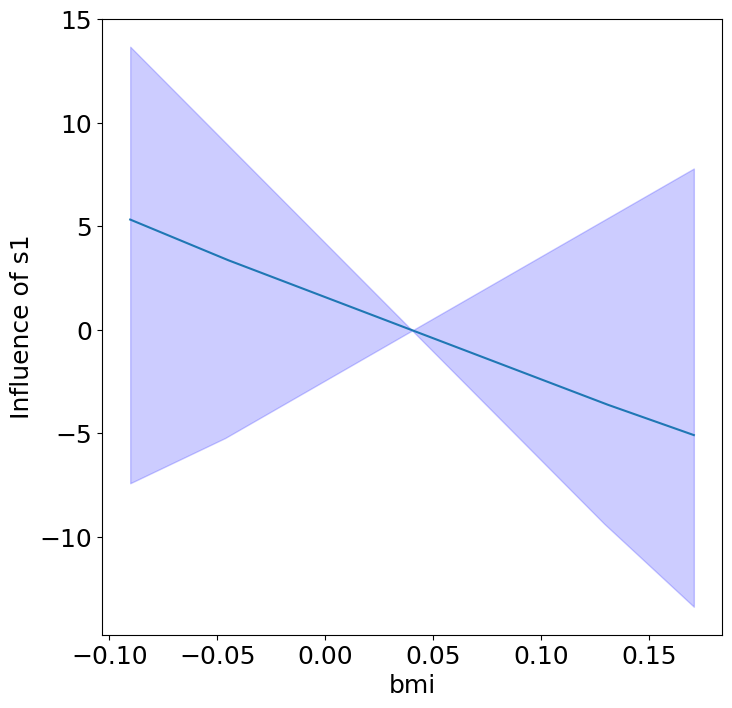

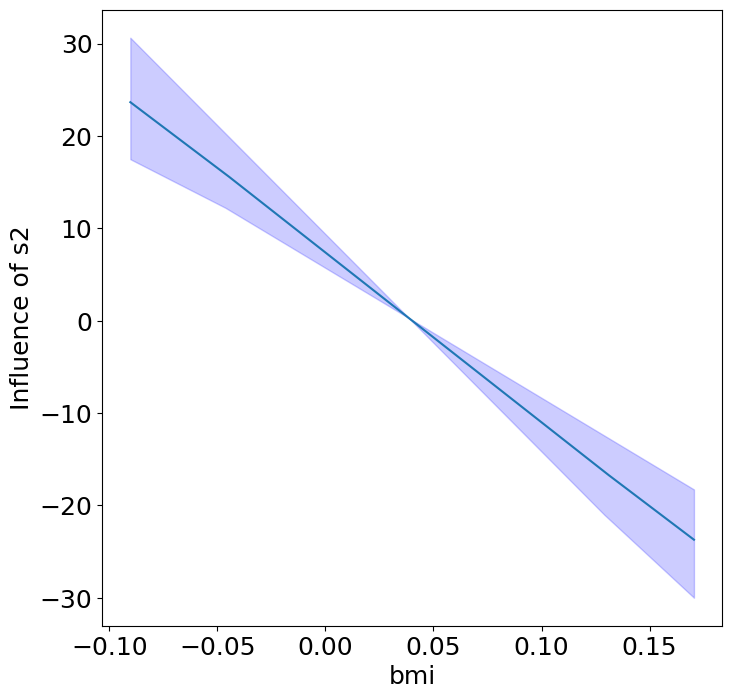

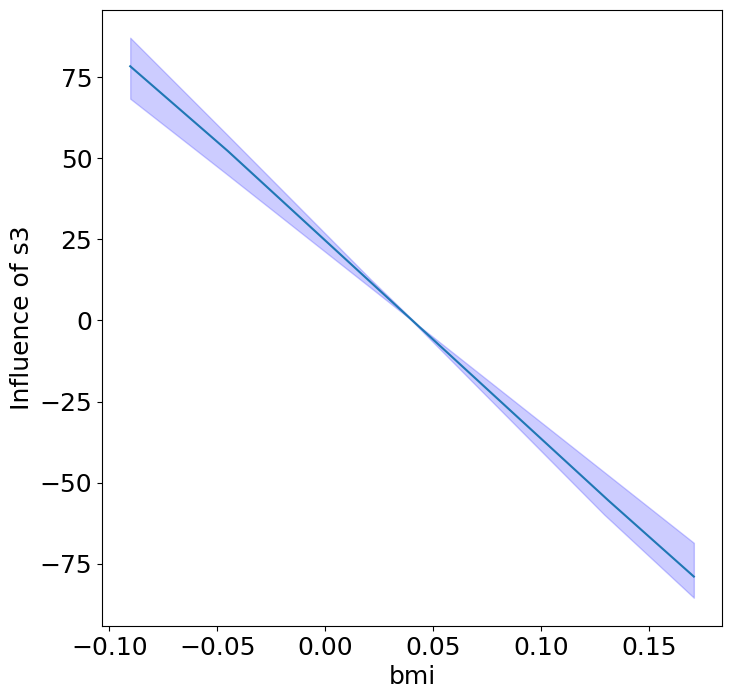

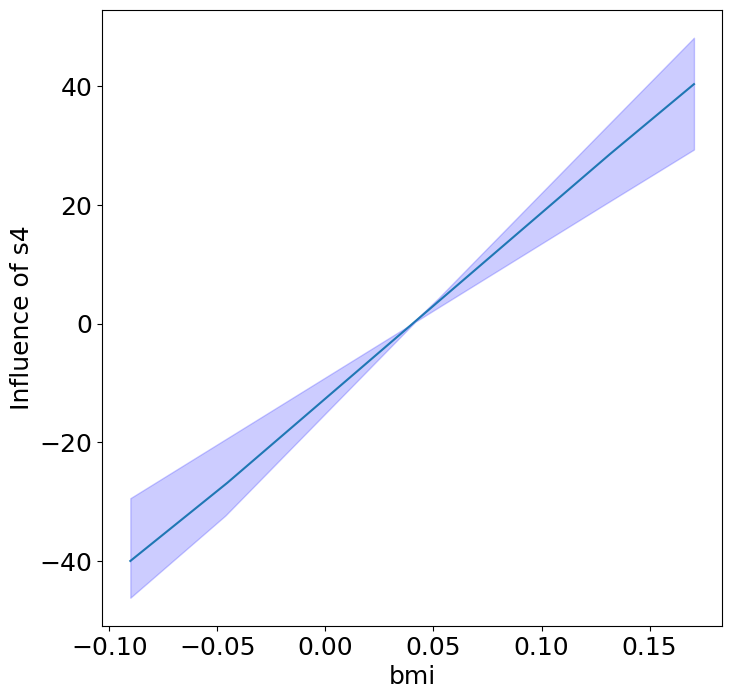

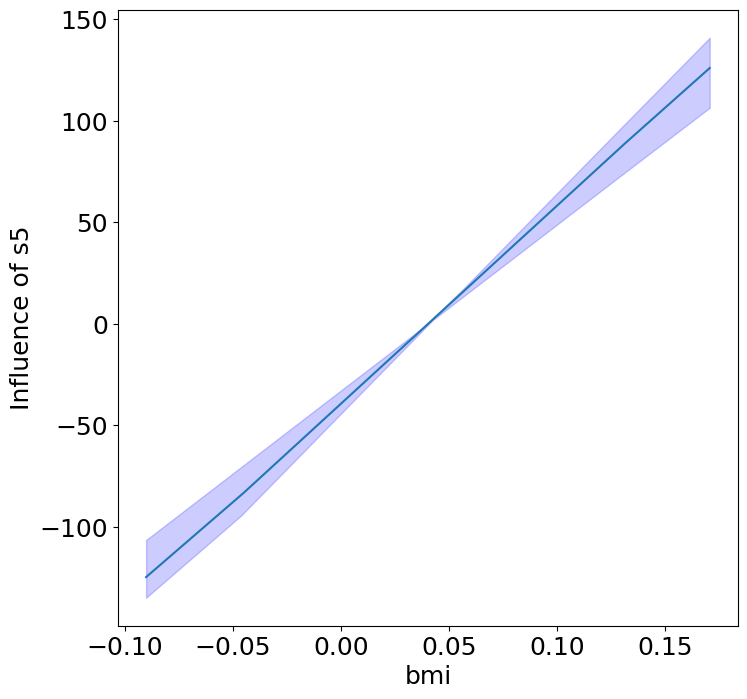

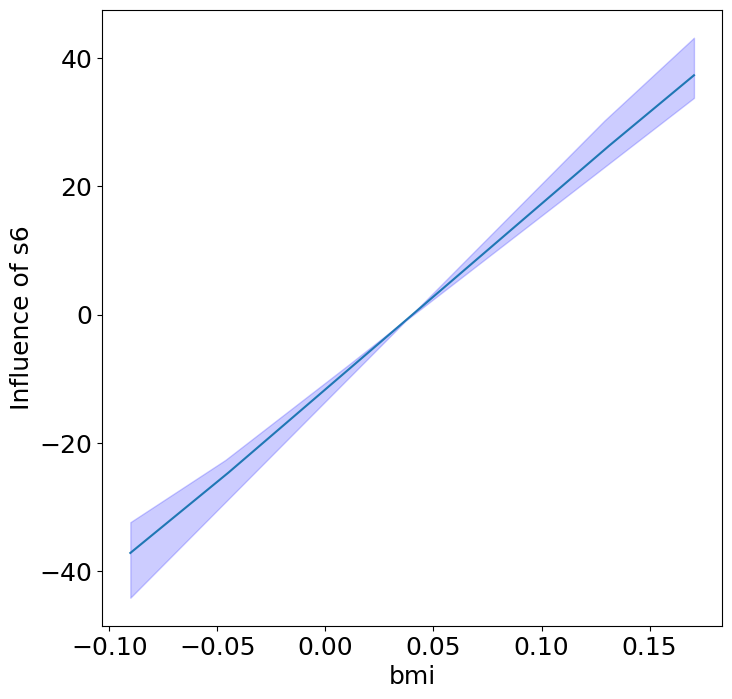

In [12]:
plot_heterogeneous_predictor_effects(model, C, X, min_effect_size=50,
                  ylabel="Influence of")